### Neuroevolution:
- Bild -> preprocessing -> CNN -> MLP -> Eingabe (NES controller)
- CNN und MLP basieren auf pytorch
- Es wird der gegebene Reward von super mario gym genommen

#### ToDo:
- Hilfsplott mit wichtigen Informationen zum aktuellen training: Anzahl in Prozent wie viele Agenten aus Mutationen von Eliteagenten in aktueller Generation enstanden sind
- Hyperparameter suche?
- Dynamische Mutation (z.B: erhöhe Mutationsstärke bei Stillstand)
- Gespeicherte models nochmal finetunen, testen, überüfen ob die wirklich konstant gute Ergebnisse haben

#### Models müssen gespeichert und geladen werden können
- Benötigt sind: cnn_config, mlp_config, die eigentlichen gewichte, input_channels, action_set
- Codiere im Dateinamen: fitness_{}
- Möglichkeit die besten n models zu speichern

#### Nice to have:
- Verbesserung der GPU Auslastung (Hat sich als schwierig herausgestellt, im Moment ist cpu-only schneller!)
- Frame skipping um performance zu erhöhen (Auch schwierig hauptlast ist nicht die entscheidung des agenten sondern die laufende mario umgebung)
- Percentage clipping für die eliteagents?

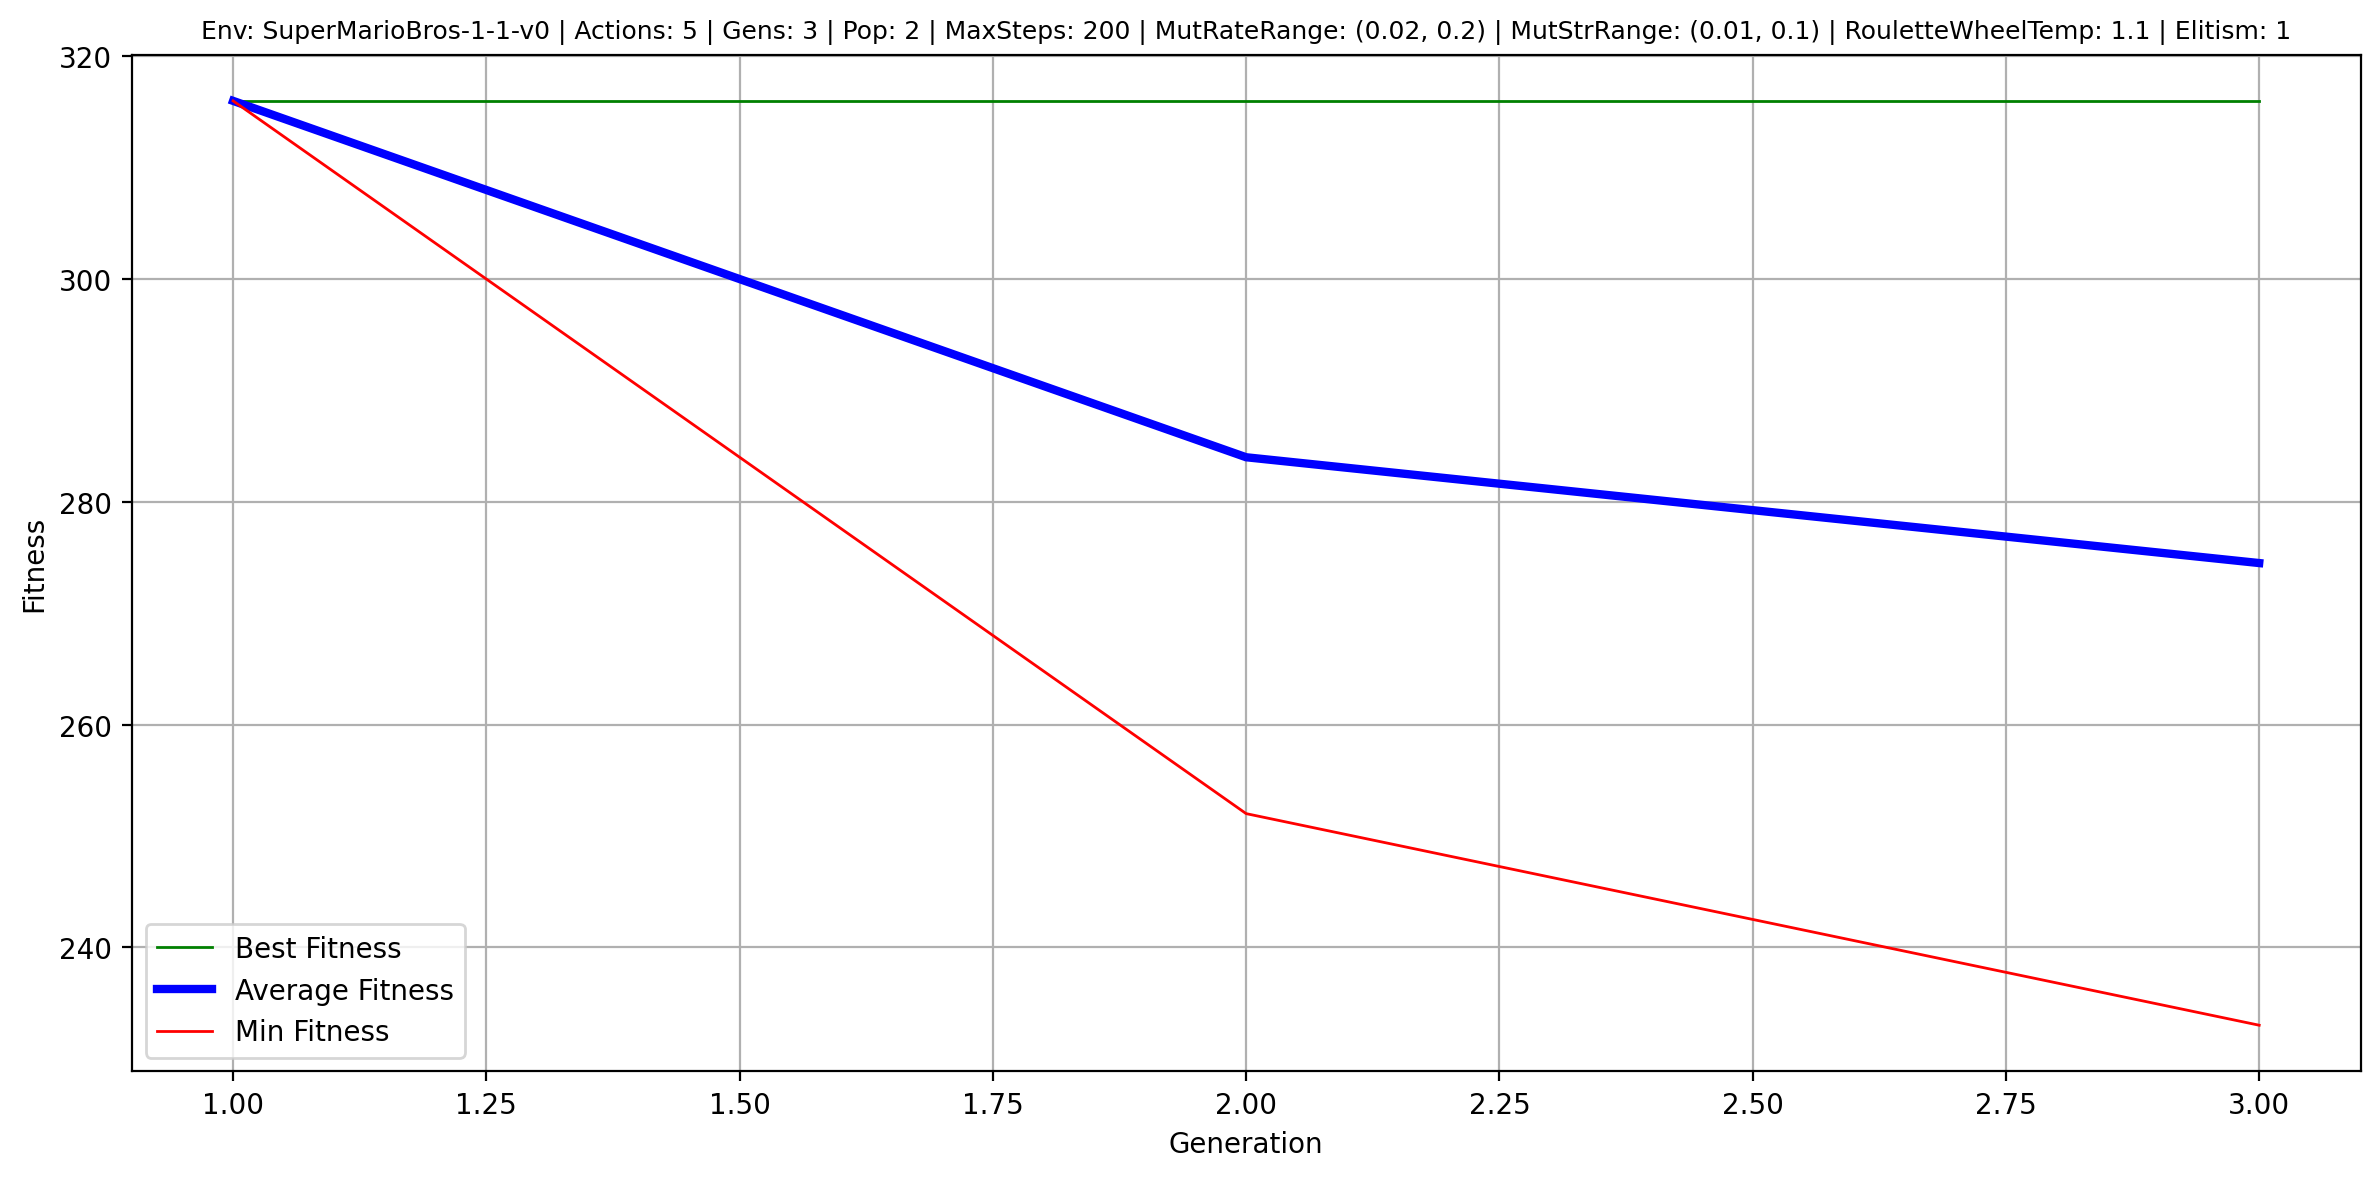

/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/babajane/Library/Mobile Documents/com~apple~CloudDocs/realRoot/uni/mac/6Semester/cognitiveComputing/SuperMarioReinforcementLearningProject/runs/neuroevolution/max_fit_316__avg_fit_291__env_name_SuperMarioBros-1-1-v0__action_set_5 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/babajane/Library/Python/3.9/lib/python/site-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] i


Running best agent for recording...

Final fitness: 316.00
Video saved to: ../runs/neuroevolution/max_fit_316__avg_fit_291__env_name_SuperMarioBros-1-1-v0__action_set_5/fitness_316.0.mp4
Fitness plot saved to ../runs/neuroevolution/max_fit_316__avg_fit_291__env_name_SuperMarioBros-1-1-v0__action_set_5/fitness_plot.png
Best model saved to ../runs/neuroevolution/max_fit_316__avg_fit_291__env_name_SuperMarioBros-1-1-v0__action_set_5/best_model_316.0.pt


In [3]:
import torch
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT, RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

DEVICE = "cpu"  #torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_config = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]

mlp_config = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]

model = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(RIGHT_ONLY),
    cnn_config=cnn_config,
    mlp_config=mlp_config
)

trainer = NeuroevolutionTrainer(
    base_model=model,
    env_name='SuperMarioBros-1-1-v0',
    action_set=RIGHT_ONLY,
    device=DEVICE,
    directory="../runs/neuroevolution",
    generations=3,
    population_size=2,
    max_steps_per_episode=200,
    mutation_rate_range=(0.02, 0.2),
    mutation_strength_range=(0.01, 0.1),
    roulette_wheel_selection_temperature=1.1,
    elitism=1
)

trainer.run()
trainer.record_best_agent()
trainer.save_metrics()
trainer.save_best_model()